# Score

> Scoring functions to calculate kinase score based on substrate sequence

## Setup

In [60]:
#| default_exp score

In [61]:
#| export
import numpy as np, pandas as pd
from katlas.data import *
from katlas.utils import *
from typing import Callable
from functools import partial

```python
from katlas.score import *
```

## Algorithms

### Multiply

In [3]:
#| export
def multiply_func(values, # list of values, possibilities of amino acids at certain positions
             factor=17, # scale factor
            ):
    
    "Multiply the possibilities of the amino acids at each position in a phosphorylation site"
    

    # Using the logarithmic property: log(a*b) = log(a) + log(b)
    # Compute the sum of the logarithms of the values and the scale factor
    log_sum = np.sum(np.log2(values)) + (len(values) - 1) * np.log2(factor)

    return log_sum

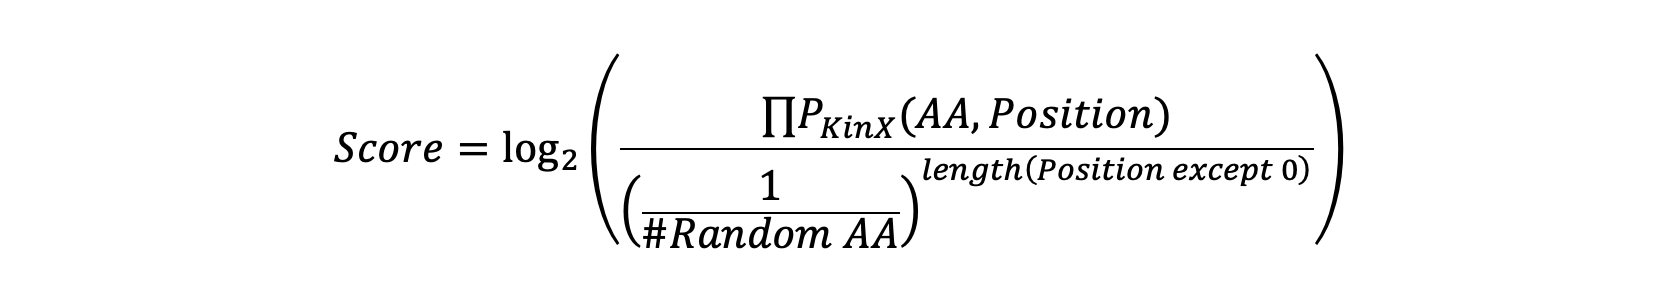

The function implement formula from [Johnson et al. Nature: An atlas of substrate specificities for the human serine/threonine kinome, Supplementary Note2](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-022-05575-3/MediaObjects/41586_2022_5575_MOESM1_ESM.pdf) (page 160)

Multiply class, consider the dynamics of scale factor

In [4]:
#| export
def multiply(values, kinase, num_dict=Data.get_num_dict()):
    "Multiply values, consider the dynamics of scale factor, which is PSPA random aa number."

    # Check if any values are less than or equal to zero
    if np.any(np.array(values) == 0):
        return np.nan
    else:
        # Retrieve the divide factor from the dictionary
        divide_factor = num_dict[kinase]

        # Using the logarithmic property: log(a*b) = log(a) + log(b)
        # Compute the sum of the logarithms of the values and the divide factor
        log_sum = np.sum(np.log2(values)) + (len(values) - 1) * np.log2(divide_factor)

        return log_sum

In [5]:
multiply(values=[1,2,3,4,5],kinase='PDHK1')

22.906890595608516

### Log odds

### Background frequencies

In [1]:
from katlas.data import *

In [2]:
bg = Data.get_ks_background()

In [4]:
bg.loc['ks_ST']

-20P    0.07050
-20G    0.06744
-20A    0.07543
-20C    0.01520
-20S    0.05042
         ...   
20D     0.05601
20E     0.07712
20s     0.04108
20t     0.01644
20y     0.00721
Name: ks_ST, Length: 943, dtype: float64

In [48]:
ks_seqs = Data.get_ks_unique()

In [51]:
st = ks_seqs[ks_seqs.acceptor!='Y']
y = ks_seqs[ks_seqs.acceptor=='Y']

In [53]:
st.site_seq

0        TDRGSGKKRGFAFVTFDDHDsVDKIVIQKYHTVNGHNCEVR
1        SKSEsPKEPEQLRKLFIGGLsFEtTDESLRSHFEQWGTLTD
2        _______________MSKSEsPKEPEQLRKLFIGGLsFEtT
3        RPHKVDGRVVEPKRAVSREDsQRPDAHLTVKKIFVGGIKED
4        EsPKEPEQLRKLFIGGLsFEtTDESLRSHFEQWGTLTDCVV
                           ...                    
29803    KQLTEKIRQQQEKLEALQKTtPIRSQADLKKLPLEVTTRPS
29804    PsLLPNsKsPREVPSPKVIKtPVVKKtEsPIKLsPAtPsRK
29805    KVIKtPVVKKtEsPIKLsPAtPsRKRsVAVsDEEEVEEEAE
29806    FISSLKSAWQTLNEFARAHtsstQLQEELEKVANQIKEEEE
29807    GFISSLKSAWQTLNEFARAHtsstQLQEELEKVANQIKEEE
Name: site_seq, Length: 22743, dtype: object

In [49]:
ks_seqs.site_seq

,sub_site,num_kin,bin,sub_genes,site_seq,source_combine,acceptor,O00141_SGK1,O00238_BMPR1B,O00311_CDC7,...,Q9Y2K2_SIK3,Q9Y2U5_MAP3K2,Q9Y3S1_WNK2,Q9Y463_DYRK1B,Q9Y4K4_MAP4K5,Q9Y572_RIPK3,Q9Y5S2_CDC42BPB,Q9Y6E0_STK24,Q9Y6M4_CSNK1G3,Q9Y6R4_MAP3K4
0,A0A2R8Y4L2_S158,1,1,HNRNPA1L3 HNRNPA1P48,TDRGSGKKRGFAFVTFDDHDsVDKIVIQKYHTVNGHNCEVR,Sugiyama,S,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A0A2R8Y4L2_S22,3,2~10,HNRNPA1L3 HNRNPA1P48,SKSEsPKEPEQLRKLFIGGLsFEtTDESLRSHFEQWGTLTD,Sugiyama,S,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A0A2R8Y4L2_S6,3,2~10,HNRNPA1L3 HNRNPA1P48,_______________MSKSEsPKEPEQLRKLFIGGLsFEtT,Sugiyama,S,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A0A2R8Y4L2_S95,65,11~100,HNRNPA1L3 HNRNPA1P48,RPHKVDGRVVEPKRAVSREDsQRPDAHLTVKKIFVGGIKED,Sugiyama,S,0,1,0,...,0,1,0,0,1,0,0,0,0,0
4,A0A2R8Y4L2_T25,3,2~10,HNRNPA1L3 HNRNPA1P48,EsPKEPEQLRKLFIGGLsFEtTDESLRSHFEQWGTLTDCVV,Sugiyama,T,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29806,Q9Y6Y8_S894,2,2~10,SEC23IP MSTP053,FISSLKSAWQTLNEFARAHtsstQLQEELEKVANQIKEEEE,Sugiyama,S,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29807,Q9Y6Y8_T893,4,2~10,SEC23IP MSTP053,GFISSLKSAWQTLNEFARAHtsstQLQEELEKVANQIKEEE,Sugiyama,T,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29808,Q9Y6Y8_Y935,2,2~10,SEC23IP MSTP053,KQVVEAEKVVEsPDFsKDEDyLGKVGMLNGGRRIDYVLQEK,Sugiyama,Y,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29809,Q9Y6Y9_Y131,1,1,LY96 ESOP1 MD2,ETVNTTISFSFKGIKFSKGKyKCVVEAISGSPEEMLFCLEF,Non-Sugiyama,Y,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def log_odds(values, kinase):
    if any(v <= 0 or bg_freq.get(aa, 0) <= 0 for v, aa in zip(values, residues)):
        return np.nan

    log_odds = [np.log2(v / bg_freq[aa]) for v, aa in zip(values, residues)]

### Sum

In [6]:
#| export
def sumup(values, # list of values, possibilities of amino acids at certain positions
          kinase=None, 
         ):
    "Sum up the possibilities of the amino acids at each position in a phosphorylation site sequence"
    return sum(values)

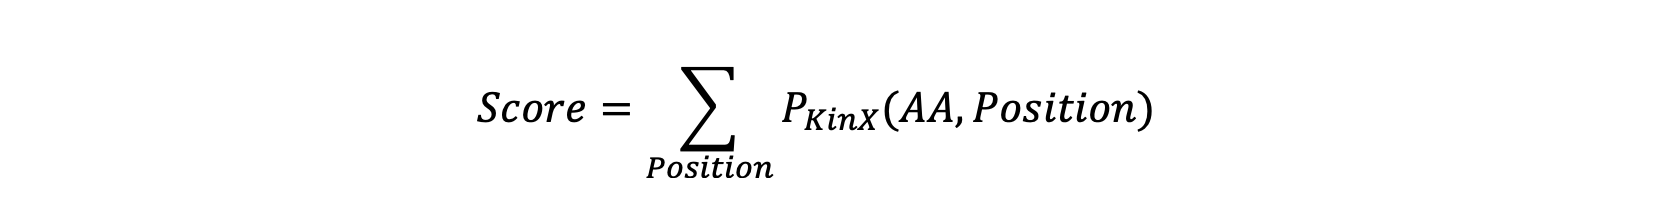

## Utils

In [7]:
#| export
def STY2sty(input_string: str):
    "Replace all 'STY' with 'sty' in a sequence"    
    return input_string.replace('S', 's').replace('T', 't').replace('Y', 'y')

In [8]:
STY2sty('AAkUuPSFSTtH') # convert all capital STY to sty in a string

'AAkUuPsFsttH'

In [9]:
#| export
def get_dict(input_string:str, # phosphorylation site sequence
            ):
    
    "Get a dictionary of input string; no need for the star in the middle; make sure it is 15 or 10 length"

    center_index = len(input_string) // 2
    center_char = input_string[center_index]

    result = []

    for i, char in enumerate(input_string):
        position = i - center_index

        if char.isalpha():
            result.append(f"{position}{char}")

    return result

In [10]:
cols = get_dict("PSVEPPLsQETFSDL")
cols

['-7P',
 '-6S',
 '-5V',
 '-4E',
 '-3P',
 '-2P',
 '-1L',
 '0s',
 '1Q',
 '2E',
 '3T',
 '4F',
 '5S',
 '6D',
 '7L']

## Scoring func

In [44]:
#| export
def predict_kinase(input_string: str, # site sequence
                   ref: pd.DataFrame, # reference dataframe for scoring
                   func: Callable, # function to calculate score
                   to_lower: bool=False, # convert capital STY to lower case
                   to_upper: bool=False, # convert all letter to uppercase
                   verbose=True
                   ):
    "Predict kinase given a phosphorylation site sequence"
 
    input_string = check_seq(input_string)

    if to_lower:
        input_string = STY2sty(input_string)

    if to_upper:
        input_string = input_string.upper()

    # if ref contains pS,pT,pY columns, convert them to s,t,y for scoring
    ref=ref.copy()
    ref.columns=ref.columns.map(pSTY2sty)
    
    results = []
    
    for kinase, row in ref.iterrows():
        
        # Convert the row into a dictionary, excluding NaN values, to create a PSSM dictionary for a kinase
        r_dict = row.dropna().to_dict()
        
        # Extract position+amino acid name from the input string and filter them against the name in PSSM
        pos_aa_name = get_dict(input_string)
        pos_aa_name = [key for key in pos_aa_name if key in r_dict.keys()]
    
        # Collect corresponding PSSM values for these positions and amino acids
        pos_aa_val = [r_dict[key] for key in pos_aa_name] # Further checks for NaN values
        
        # Calculate the score for this kinase using the specified function
        score = func(pos_aa_val, kinase)
        results.append(score)
    
    if verbose:
        print(f'considering string: {pos_aa_name}')

    out = pd.Series(results, index=ref.index).sort_values(ascending=False)
        
    return out.round(3).dropna()

In [45]:
predict_kinase("PSVEPPLsQETFSDL",pspa_scale,multiply)

considering string: ['-5V', '-4E', '-3P', '-2P', '-1L', '0s', '1Q', '2E', '3T', '4F']


kinase
ATM        0.167
SMG1      -0.060
DNAPK     -0.714
FAM20C    -1.216
ATR       -1.321
           ...  
PKCI     -11.319
NEK3     -11.455
CK1A     -11.686
CK1G3    -13.182
CK1G2    -13.421
Length: 303, dtype: float64

In [38]:
ref = Data.get_pspa_st_norm().astype('float32')

In [13]:
predict_kinase("PSVEPPLsQETFSDL",ref,multiply)

considering string: ['-5V', '-4E', '-3P', '-2P', '-1L', '0s', '1Q', '2E', '3T', '4F']


kinase
ATM       5.037
SMG1      4.385
DNAPK     3.818
ATR       3.507
FAM20C    3.170
          ...  
PKN1     -7.275
P70S6K   -7.295
AKT3     -7.375
PKCI     -7.742
NEK3     -8.254
Length: 303, dtype: float64

## Params

Here we provide different PSSM settings from either PSPA data or kinase-substrate dataset for kinase prediction:

In [14]:
#| export
def Params(name=None):
    params = {
        "PSPA_st": {'ref': Data.get_pspa_st_norm().astype('float32'), 'func': multiply},
        "PSPA_y": {'ref': Data.get_pspa_tyr_norm().astype('float32'), 'func': multiply},
        "PSPA": {'ref': Data.get_pspa_all_norm().astype('float32'), 'func': multiply},
        "CDDM": {'ref': Data.get_cddm().astype('float32'), 'func': sumup},
        "CDDM_upper": {'ref': Data.get_cddm_upper().astype('float32'), 'func': sumup, 'to_upper': True},
    }
    
    if name is None:
        print("Available parameter sets:")
        return list(params.keys())
    
    if name in params:
        return params[name]
    
    raise ValueError(f"Unknown parameter set: {name}. Use Params() to list available options.")

In [15]:
Params()

Available parameter sets:


['PSPA_st', 'PSPA_y', 'PSPA', 'CDDM', 'CDDM_upper']

In [16]:
for p in ['PSPA', 'CDDM','CDDM_upper']:
    print(predict_kinase("PSVEPPLsQETFSDL",**Params(p)).head())

considering string: ['-5V', '-4E', '-3P', '-2P', '-1L', '0s', '1Q', '2E', '3T', '4F', '5S']
kinase
ATM       5.037
SMG1      4.385
DNAPK     3.818
ATR       3.507
FAM20C    3.170
dtype: float64
considering string: ['-7P', '-6S', '-5V', '-4E', '-3P', '-2P', '-1L', '0s', '1Q', '2E', '3T', '4F', '5S', '6D', '7L']
kinase
ATR      3.064
ATM      2.909
DNAPK    2.270
CK2A1    1.873
TSSK1    1.856
dtype: float64
considering string: ['-7P', '-6S', '-5V', '-4E', '-3P', '-2P', '-1L', '0S', '1Q', '2E', '3T', '4F', '5S', '6D', '7L']
kinase
ATR      3.229
ATM      3.038
DNAPK    2.479
CK2A1    2.006
CDK8     1.999
dtype: float64


## Score sequences in df

In [17]:
#| export 
def cut_seq(input_string: str, # site sequence
            min_position: int, # minimum position relative to its center
            max_position: int, # maximum position relative to its center
            ):
    
    "Extract sequence based on a range relative to its center position"
    
    # Find the center position of the string
    center_position = len(input_string) // 2

    # Calculate the start and end indices
    start_index = max(center_position + min_position, 0)  # Ensure start_index is not negative
    end_index = min(center_position + max_position + 1, len(input_string))  # Ensure end_index does not exceed string length

    # Extract and return the substring
    return input_string[start_index:end_index]

In [18]:
cut_seq('AAkUuPSFSTtH',-5,4)

'AkUuPSFSTt'

In [19]:
cut_seq('AAkUuPSFSTtH',-50,40)

'AAkUuPSFSTtH'

In [ ]:
#| export
def predict_kinase_df(df, seq_col, ref, func, to_lower=False, to_upper=False):
    
    print('input dataframe has a length', df.shape[0])
    print('Preprocessing')
    
    df = df.copy()
    
    df[seq_col] = check_seq_df(df, seq_col)
    
    if to_lower:
        df[seq_col] = df[seq_col].apply(STY2sty)
        
    if to_upper:
        df[seq_col] = df[seq_col].str.upper()
        
    # Adjust sequence lengths to match the reference matrix's expected inputs
    # Cut only work when ref is shorter than the input sequence
    max_value = ref.columns.str[:-1].astype(int).max() # Get the highest position index from the reference columns
    min_value = ref.columns.str[:-1].astype(int).min() # Get the lowest position index
    df[seq_col] = df[seq_col].apply(partial(cut_seq, min_position=min_value, max_position=max_value))
    
    print('Finish preprocessing')
    
    
    # wide form to long form
    df['keys'] = df[seq_col].apply(get_dict)
    input_keys_df  = df[['keys']].explode('keys').reset_index()
    input_keys_df.columns = ['input_index', 'key']
    
    
    ref_T = ref.T
    
    input_keys_df = input_keys_df.set_index('key')
    
    
    print('Merging reference')
    merged_df = input_keys_df.merge(ref_T, left_index=True, right_index=True, how='inner')

    print('Finish merging')
    
    if func == sumup:
        grouped_df = merged_df.groupby('input_index').sum()
        out = grouped_df.reindex(df.index)
         
    elif func==multiply:
        # Get the list of kinases and num_dict
        kinases = ref_T.columns
        num_dict = Data.get_num_dict()
        
        out = {}
        for kinase in tqdm(kinases):
            divide_factor = num_dict[kinase]
            # Extract data for this kinase
            kinase_df = merged_df[['input_index', kinase]].copy()
            kinase_df = kinase_df.rename(columns={kinase: 'value'})

            # Compute log_value
            kinase_df['log_value'] = np.log2(kinase_df['value'].where(kinase_df['value'] > 0))

            # Group by 'input_index' and compute sum and count
            grouped = kinase_df.dropna().groupby('input_index')
            sum_log_values = grouped['log_value'].sum()
            len_values = grouped['log_value'].count()

            # Compute log_sum using the formula
            log_sum = sum_log_values + (len_values - 1) * np.log2(divide_factor)

            # Find all 'input_index' where 'log_value' is NaN
            nan_input_indices = kinase_df.loc[kinase_df['value']==0, 'input_index'].unique()
            # Set log_sum at those indices to NaN
            log_sum.loc[nan_input_indices] = np.nan

            # Assign the computed values to the results DataFrame
            out[kinase] = log_sum

        out = pd.DataFrame(out).reindex(df.index)
        
    else:
        grouped_df = merged_df.drop(columns=['key']).groupby('input_index').agg(func)
        out = grouped_df.reindex(df.index)
        
    # Get results as a DataFrame
    return out

In [ ]:
df = Data.get_psp_human_site()
df_sty = df[df['site_seq'].str[7].isin(list('sty'))]

In [ ]:
%%time
out_cddm = predict_kinase_df(df_sty.head(500),'site_seq', **Params('CDDM'))

input dataframe has a length 500
Preprocessing
Finish preprocessing
Merging reference
Finish merging
CPU times: user 28 ms, sys: 12 ms, total: 40 ms
Wall time: 39.9 ms


## Percentile scoring

In [ ]:
#| export
def get_pct(site,ref,func,pct_ref):
    
    "Replicate the precentile results from The Kinase Library."
    
    # As here we try to replicate the results, we use site.upper(); consider removing it for future version.
    score = predict_kinase(site.upper(),ref=ref,func=func)
    
    percentiles = {}
    for kinase in score.index: 
        # Get the values from `ref` for this kinase
        ref_values = pct_ref[kinase].values
        # Calculate how many values in `ref` are less than the new score
        less = np.sum(ref_values < score[kinase])
        # Calculate how many values are equal to the new score
        equal = np.sum(ref_values == score[kinase])
        # Calculate the percentile rank
        percentile = (less + 0.5 * equal) / len(ref_values) * 100
        percentiles[kinase] = percentile
        
    pct = pd.Series(percentiles)
    final = pd.concat([score,pct],axis=1)
    final.columns=['log2(score)','percentile']
    return final

In [ ]:
st_pct = Data.get_pspa_st_pct()
y_pct = Data.get_pspa_tyr_pct()

In [ ]:
out = get_pct('PSVEPPLyQETFSDL',**Params('PSPA_y'), pct_ref=y_pct)
out.sort_values('percentile',ascending=False)

considering string: ['-5V', '-4E', '-3P', '-2P', '-1L', '0Y', '1Q', '2E', '3T', '4F', '5S']


,log2(score),percentile
ABL2,3.137,96.568694
BMX,2.816,96.117567
BTK,1.956,95.693780
CSK,2.303,95.174299
MERTK,2.509,93.588517
...,...,...
FLT1,-1.919,25.358852
PINK1_TYR,-1.227,21.927546
MUSK,-3.031,21.298701
TNNI3K_TYR,-3.549,11.004785


In [ ]:
get_pct('PSVEPPLsQETFSDL',**Params('PSPA_st'), pct_ref=st_pct)

considering string: ['-5V', '-4E', '-3P', '-2P', '-1L', '0S', '1Q', '2E', '3T', '4F']


,log2(score),percentile
ATM,5.037,99.822351
SMG1,4.385,99.831819
DNAPK,3.818,99.205315
ATR,3.507,99.680344
FAM20C,3.170,95.370556
...,...,...
PKN1,-7.275,14.070436
P70S6K,-7.295,4.089816
AKT3,-7.375,11.432995
PKCI,-7.742,8.129511


In [ ]:
#| export
def get_pct_df(score_df, # output from predict_kinase_df 
               pct_ref, # a reference df for percentile calculation
              ):
    
    "Replicate the precentile results from The Kinase Library."

    # Create an array to hold percentile ranks
    percentiles = np.zeros(score_df.shape)
    
    # Calculate percentiles for each column in a vectorized manner
    for i, kinase in tqdm(enumerate(score_df.columns),total=len(score_df.columns)):
        ref_values = np.sort(pct_ref[kinase].values)
        
        # Use searchsorted to find indices where the scores would be inserted to maintain order
        indices = np.searchsorted(ref_values, score_df[kinase].values, side='right')
        
        # Calculate percentile ranks
        percentiles[:, i] = indices / len(ref_values) * 100

    # Convert the array to a DataFrame with appropriate indices and columns
    percentiles_df = pd.DataFrame(percentiles, index=score_df.index, columns=score_df.columns).astype(float).round(3)
    
    return percentiles_df

In [ ]:
# substrate score first
# score_df = predict_kinase_df(df_sty,'site_seq', **Params('PSPA_st'))

# get percentile reference
# pct_ref = Data.get_pspa_st_pct()

In [ ]:
# pct = get_pct_df(score_df,pct_ref)

## End

In [59]:
#| hide
import nbdev; nbdev.nbdev_export()